In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import datetime
import requests
import json

import xdmod.datawarehouse as xdw
import xdmod.visualizer as v
import xdmod.outlier_detection as od

from IPython.display import display, Markdown, JSON

In [2]:
# config variables

# dictionary mapping hostname -> url
hosts = {'metrics-dev': 'https://metrics-dev.ccr.buffalo.edu:9004'} #, 'ookami': 'https://ookami.ccr.xdmod.org','xdmod-dev': 'https://xdmod-dev.ccr.xdmod.org:9002'}

# config date objects
today = date.today()
sunday = today - datetime.timedelta(days=1)
last_monday = today - datetime.timedelta(days=7)
last_sunday = last_monday - datetime.timedelta(days=1)
lastlast_monday = last_monday - datetime.timedelta(days=7)

In [ ]:
# config json files for outlier detection
#od.config_json(hosts, '2022-05-01', end_date = '2022-07-01', config_all = True)

# Alerts 2022-08-17

## metrics-dev

2022-08-10    0.0
2022-08-11    0.0
2022-08-12    0.0
2022-08-13    0.0
2022-08-14    0.0
2022-08-15    0.0
2022-08-16    0.0
Name: faculty, dtype: float64


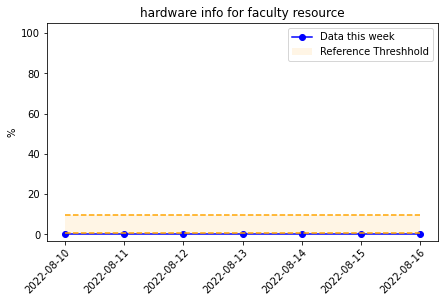

2022-08-10    0.0
2022-08-11    0.0
2022-08-12    0.0
2022-08-13    0.0
2022-08-14    0.0
2022-08-15    0.0
2022-08-16    0.0
Name: faculty, dtype: float64


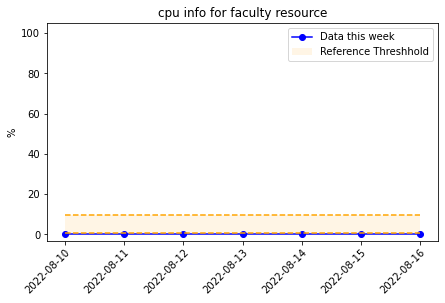

2022-08-10    100.0
2022-08-11    100.0
2022-08-12    100.0
2022-08-13    100.0
2022-08-14    100.0
2022-08-15    100.0
2022-08-16     18.0
Name: faculty, dtype: float64


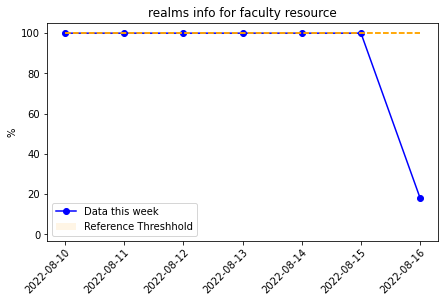

2022-08-10    100.0
2022-08-11    100.0
2022-08-12    100.0
2022-08-13    100.0
2022-08-14    100.0
2022-08-15    100.0
2022-08-16     13.0
Name: ub-hpc, dtype: float64


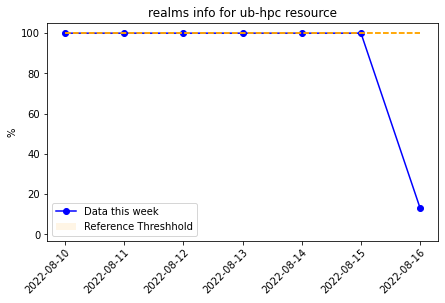

In [5]:
display(Markdown(f'# Alerts {today.strftime("%Y-%m-%d")}'))

alert_messages = {}

for host in hosts:
    display(Markdown(f'## {host}'))
    with xdw.DataWareHouse(hosts[host]) as warehouse:
        for type in ['hardware', 'cpu', 'realms']:
            today_data = warehouse.get_qualitydata({"start": last_monday, "end": sunday, "type": type})
            for res in today_data.index:
                outlier_info = od.detect_outlier(today_data, host, res)
                if outlier_info['alert']:
                    res_series = today_data.loc[res]
                    
                    fig, ax = plt.subplots(figsize=(7, 4))
                    
                    plt.plot(res_series, 'o-', color = 'b', label = 'Data this week')
                    plt.plot(np.full(len(res_series), outlier_info['ref_mean']),'--', color = 'orange') 
                    plt.fill_between(np.arange(len(res_series)),np.full(len(res_series), outlier_info['ref_mean']), np.full(len(res_series), outlier_info['ref_mean'] - outlier_info['ref_std']), facecolor= 'orange', alpha=.1, label = 'Reference Threshhold')
                    plt.plot(np.full(len(res_series), outlier_info['ref_mean'] - outlier_info['ref_std']),'--', color = 'orange')
                    
                    plt.ylim(-3,105)
                    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
                    
                    plt.ylabel('%')
                    plt.title(f'{type} info for {res} resource')
                    plt.legend()
                    fig.tight_layout
                    plt.show()
                    
                    alert_messages[host] = alert_messages.get(host, [])+[f'Attention needed at: *{type}* query for *{res}* resource']    


In [ ]:
display(Markdown(f'# Full Report {today.strftime("%Y-%m-%d")}'))

for host in hosts:
    display(Markdown(f'## {host}'))
    for type in ['gpu','hardware', 'cpu','realms']:
        config = {"start": last_monday, "end": sunday, "type": type}
        config_lastweek = {"start": lastlast_monday, "end": last_sunday, "type": type}  
        with xdw.DataWareHouse(hosts[host]) as test:
                data = test.get_qualitydata(config)
                v.quality_heatmap(data)

In [41]:
# alerts setup

# path to report in html format
html_path = f'reports/xdmod-alerts/{today.strftime("%Y-%m-%d")}_report.html'

# Slack webhook for post request
# DO NOT EXPOSE ON GITHUB
webhook = ''

In [43]:
type_to_title = {'gpu': '% of CCR SUPReMM jobs with GPU information', 
                'hardware': '% of CCR SUPReMM jobs with hardware perf information', 
                'cpu': '% of CCR SUPReMM jobs with cpu usage information', 
                'script': '% of CCR SUPReMM jobs with Job Batch Script information', 
                'realms': '% of CCR jobs in the SUPReMM realm compared to Jobs realm'}

payload = {"blocks": [{"type": "section","text": {"type": "mrkdwn","text": f'*SUPReMM Quality Alerts {today}*'}}]}

for host in hosts:
    payload['blocks'].append({"type": "divider"})
    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'*{host}*'}})
    for message in alert_messages[host]:
        payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": message}})
                    
payload['blocks'].append({"type": "divider"})
payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'{hosts["metrics-dev"]}/{html_path}'}})                
                
response = requests.post(webhook, data = json.dumps(payload))